In [2]:
import torch
import torchvision
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torch.utils.data import sampler

In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
dtype = torch.float32

device

device(type='cpu')

In [4]:
train_transform = T.Compose([
                T.ToTensor(),                
                T.RandomHorizontalFlip(p=0.5),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])
inv_transform = T.Compose([
                T.Normalize((0., 0., 0.), (1/0.2023, 1/0.1994, 1/0.2010)),
                T.Normalize((-0.4914, -0.4822, -0.4465), (1., 1. ,1. )),
                T.ToPILImage()
            ])
test_transform = T.Compose([
                T.ToTensor(),
                T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
            ])

NUM_TRAIN = 49000
ds_train = torchvision.datasets.CIFAR10('./', train=True, download=True, transform=train_transform)
ds_test  = torchvision.datasets.CIFAR10('./', train=False, download=True, transform=test_transform)

dl_train = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(0, NUM_TRAIN)))
dl_valid = DataLoader(ds_train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, 50000)))
dl_test  = DataLoader(ds_test,  batch_size=64)

splits = {
    "train": dl_train,
    "valid": dl_valid,
    "test": dl_test,
}

Files already downloaded and verified
Files already downloaded and verified


mean: -0.02
std: 1.23
max: 2.75
min: -2.43


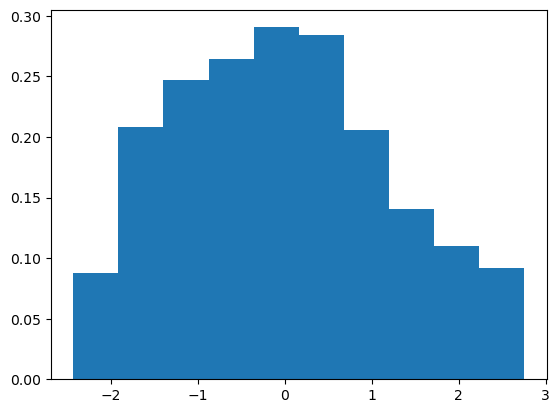

In [5]:
x, _ = next(iter(dl_train))
x = x.view(-1)
print(f"mean: {x.mean():.2f}")
print(f"std: {x.std():.2f}")
print(f"max: {x.max():.2f}")
print(f"min: {x.min():.2f}")

plt.hist(x, density=True);

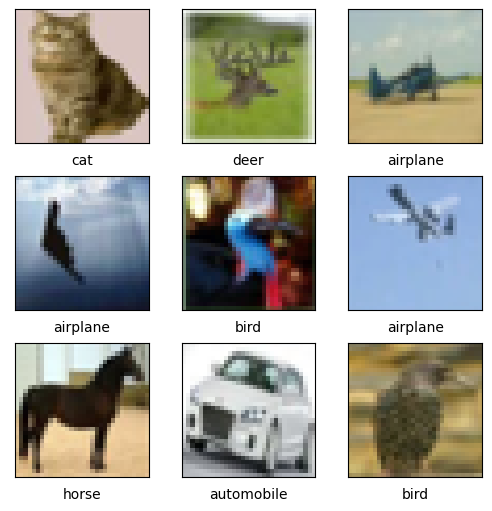

In [6]:
def plot_sample(xb, yb, pred=None):
    fig, axs = plt.subplots(3, 3, figsize=(5, 5), layout='constrained')

    for r in range(3):
        for c in range(3):
            ax = axs[r][c]
            x = xb[r*3 + c]
            y = yb[r*3 + c]
            x = inv_transform(x)
            ax.imshow(x)
            ax.set_xticks([])
            ax.set_yticks([])
            ax.set_xlabel(ds_train.classes[y])

            if pred != None:
                yh = pred[r*3 + c]
                ax.set_xlabel(ds_train.classes[yh])

                if yh != y:
                    ax.xaxis.label.set_color('r')

xb, yb = next(iter(dl_train))
plot_sample(xb, yb)

# Experiment

In [23]:
class Block(nn.Module):
    def __init__(self, channel) -> None:
        super().__init__()
        channel_bneck = channel // 4

        self.residual = nn.Sequential(
            # conv 1x1
            nn.BatchNorm2d(channel),
            nn.ReLU(),
            nn.Conv2d(channel, channel_bneck, kernel_size=1),

            # conv 3x3
            nn.BatchNorm2d(channel_bneck),
            nn.ReLU(),
            nn.Conv2d(channel_bneck, channel_bneck, kernel_size=3, padding=1),

            # conv 1x1
            nn.BatchNorm2d(channel_bneck),
            nn.ReLU(),
            nn.Conv2d(channel_bneck, channel, kernel_size=1),
        )
    
    def forward(self, x):
        out = x + self.residual(x)
        return out


class ExpandBlock(nn.Module):
    def __init__(self, channel_in, channel_out, stride) -> None:
        super().__init__()
        channel_bneck = channel_out // 4

        self.pre = nn.Sequential(
            nn.BatchNorm2d(channel_in),
            nn.ReLU()
        )

        self.residual = nn.Sequential(
            # conv 1x1
            nn.Conv2d(channel_in, channel_bneck, kernel_size=1, stride=stride),

            # conv 3x3
            nn.BatchNorm2d(channel_bneck),
            nn.ReLU(),
            nn.Conv2d(channel_bneck, channel_bneck, kernel_size=3, padding=1),

            # conv 1x1
            nn.BatchNorm2d(channel_bneck),
            nn.ReLU(),
            nn.Conv2d(channel_bneck, channel_out, kernel_size=1),
        )

        self.identity = nn.Conv2d(channel_in, channel_out, kernel_size=1, stride=stride)
    
    def forward(self, x):
        x = self.pre(x)
        out = self.identity(x) + self.residual(x)
        return out


class ResNet(nn.Module):

    def __init__(self) -> None:
        super().__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), # 32
            Block(64),
            ExpandBlock(64, 128, stride=2), # 16
            Block(128),
            nn.AvgPool2d(kernel_size=16), # 1
            nn.Flatten(),
            nn.Linear(128, 10),
        )

    def forward(self, x):
        return self.layers(x)


x, y = next(iter(dl_train))
model = ResNet()
yh = model(x)

print(f"parameter count: {sum([p.numel() for p in model.parameters()]):,}")

parameter count: 49,834


## Sanity Check

### Initial loss check

In [24]:
model = ResNet()
xb, yb = next(iter(dl_train))
yh = model(xb)
loss = F.cross_entropy(yh, yb)
loss.backward()

print("chance:", -torch.tensor(1/10).log().item())
print("loss:", loss.item())

chance: 2.3025851249694824
loss: 2.319697380065918


### Check if model has the capacity of overfit a small batch

In [27]:
model = ResNet()

xb, yb = next(iter(dl_train))
y = model(xb)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001)
xb, yb = next(iter(dl_train))

for i in range(1000):
    optimizer.zero_grad()
    yh = model(xb)
    loss = F.cross_entropy(yh, yb)
    loss.backward()
    optimizer.step()
    
    if i % 100 == 0:
        print(f"{loss.item():.4f}")

    if loss.item() < 1e-5:
        break

2.3785
1.4660
0.7110
0.2246
0.0735


Activation distribution check

In [ ]:
model = CNN()
xb, yb = next(iter(dl_train))
yh = model(xb)
loss = F.cross_entropy(yh, yb)
loss.backward()

plt.figure(figsize=(20, 4))
legends = []
for i, h in enumerate(model.h):
    print('layer %d: mean %+.2f, std %.2f, cut-off %.2f' % (i, h.mean(), h.std(), (h <= 0).to(dtype=torch.float).mean()))
    hy, hx = torch.histogram(h, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'layer {i}')

plt.legend(legends);
plt.title('activation distribution');

In [ ]:
h1 = model.h[1].view(64, -1).detach().numpy()
h = h1[:, 1000:2000]
plt.figure(figsize=(10, 10))
plt.imshow(h)

h1.mean(), h1.std()

In [ ]:
plt.figure(figsize=(20, 4))
legends = []
layers = [m for m in model.children() if "Conv" in str(m) or "Linear" in str(m)]

for i, m in enumerate(layers):
    t = m.weight.grad
    print('%d %s: mean %+.4f, std %.4f, zero: %.4f%%' % (i, str(m)[0:4], t.mean(), t.std(), (t.abs() < 0.0001).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f'{i}: {str(m)}')

plt.legend(legends);
plt.title('gradient distribution');

## Utility

In [7]:
@torch.no_grad()
def eval_split(split, model, sample_size=None):
    model.eval()
    dl = splits[split]

    num_correct = 0
    num_sample = 0
    lossi = []
    i = 0

    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device)

        logits = model(xb)
        loss = F.cross_entropy(logits, yb)
        lossi.append(loss.item())

        _, idx = logits.max(1)
        num_correct += (yb == idx).sum()
        num_sample += len(yb)

        i += len(xb)
        if sample_size and i >= sample_size:
            break

    accuracy = float(num_correct) / num_sample
    loss = torch.tensor(lossi).mean().item()
    model.train()

    return loss, accuracy

## Training

In [72]:
%%time

# model = CNN()
# model = model.to(device=device)
# model.train()

dl = splits["train"]
epoch = 2
i = 0
n = len(dl) * epoch

# metrics = []
# update_ratio = []
# optimizer = torch.optim.AdamW(model.parameters())

for _ in range(epoch):
    for xb, yb in dl:
        xb = xb.to(device=device, dtype=dtype)
        yb = yb.to(device=device)
        optimizer.zero_grad()

        logits = model(xb)
        loss = torch.nn.functional.cross_entropy(logits, yb)
        loss.backward()
        
        if i % 40 == 0:
            tr_loss, tr_acc = eval_split("train", model, sample_size=1024)
            va_loss, va_acc = eval_split("valid", model, sample_size=1024)
            # update_ratio = [grad_ratio(p) for p in model.parameters() if p.dim() == 2]
            metrics.append((tr_loss, tr_acc, va_loss, va_acc))
            print(f"{int(i/n*100)}%: {tr_loss:.2f} {va_loss:.2f} {tr_acc:.2f} {va_acc:.2f}")
        
        i += 1
        optimizer.step()

0%: 0.35 0.46 0.89 0.85
2%: 0.32 0.46 0.90 0.85
5%: 0.31 0.49 0.90 0.85
7%: 0.40 0.52 0.87 0.83
10%: 0.37 0.50 0.88 0.84
13%: 0.37 0.48 0.87 0.85
15%: 0.40 0.58 0.90 0.85
18%: 0.32 0.49 0.90 0.84
20%: 0.41 0.51 0.88 0.84
23%: 0.35 0.46 0.89 0.85
26%: 0.32 0.47 0.90 0.86
28%: 0.38 0.47 0.86 0.86
31%: 0.32 0.45 0.89 0.86
33%: 0.32 0.49 0.89 0.84
36%: 0.29 0.44 0.90 0.87
39%: 0.29 0.43 0.90 0.86
41%: 0.32 0.45 0.90 0.86
44%: 0.35 0.45 0.92 0.85
46%: 0.30 0.43 0.90 0.87
49%: 0.32 0.51 0.88 0.86
52%: 0.29 0.46 0.91 0.87
54%: 0.31 0.51 0.89 0.85
57%: 0.33 0.57 0.90 0.84
60%: 0.29 0.56 0.90 0.85
62%: 0.27 0.43 0.90 0.86
65%: 0.28 0.48 0.90 0.86
67%: 0.31 0.48 0.90 0.86
70%: 0.27 0.43 0.92 0.87
73%: 0.33 0.42 0.89 0.87
75%: 0.26 0.41 0.92 0.86
78%: 0.28 0.46 0.92 0.87
80%: 0.32 0.46 0.91 0.86
83%: 0.29 0.44 0.92 0.85
86%: 0.32 0.45 0.90 0.85
88%: 0.24 0.45 0.93 0.86
91%: 0.28 0.52 0.91 0.86
93%: 0.25 0.40 0.93 0.86
96%: 0.24 0.43 0.92 0.88
99%: 0.26 0.43 0.91 0.86
CPU times: user 2min 11s, sys

In [73]:
tr_loss, tr_acc = eval_split("train", model)
va_loss, va_acc = eval_split("valid", model)

print(f"train: {tr_loss:.2f} {tr_acc:.2f}")
print(f"valid: {va_loss:.2f} {va_acc:.2f}")

train: 0.27 0.91
valid: 0.41 0.87


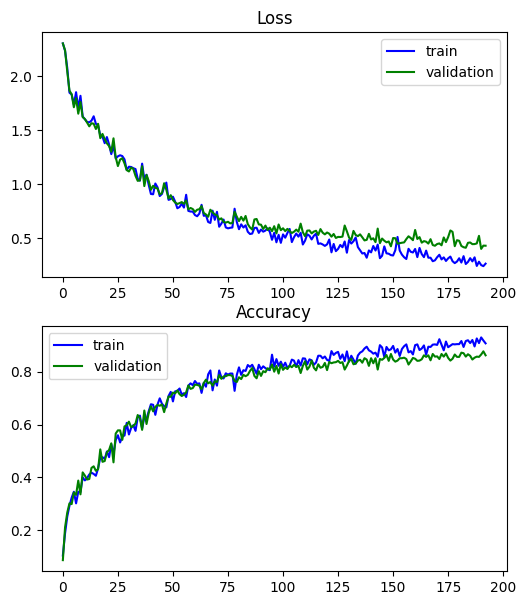

In [74]:
# plot loss and accuracy, one on left and another on the right
tr_loss, tr_acc, va_loss, va_acc = zip(*metrics)

plt.figure(figsize=(6, 7))

plt.subplot(2, 1, 1)
plt.plot(tr_loss, label="train", color="b")
plt.plot(va_loss, label="validation", color="g")
plt.title("Loss")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tr_acc, label="train", color="b")
plt.plot(va_acc, label="validation", color="g")
plt.title("Accuracy")
plt.legend()

In [71]:
@torch.no_grad()
def predict(x):
    model.eval()
    x = x.to(device=device, dtype=dtype)
    logits = model(x)
    prob = F.softmax(logits, dim=1)
    yh = torch.argmax(prob, dim=1)
    model.train()
    return yh

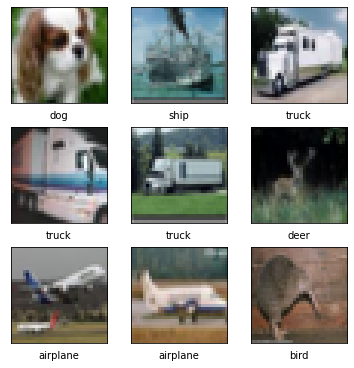

In [ ]:
xb, yb = next(iter(dl_valid))
pred = predict(xb)

plot_sample(xb, yb, pred)

In [75]:
eval_split("test", model)

(0.45819005370140076, 0.8542)